# 0. Librairies utilisées

In [51]:
# pip install dython redémarrer jupyter après
from dython.nominal import associations, identify_nominal_columns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import pearsonr, chi2_contingency
import statsmodels.api

%matplotlib inline

# Sommaire

- ### [1. Exploration des données](#1)
- ### [2. Nettoyage des données](#2)
- ### [3. Analyse descriptive](#3)
- ### [3.1. Liaisons entre les variables](#3.1)
- ### [3.2. Analyse des liaisons entre les variables catégorielles](#3.2)
- ### [3.3. Liaison entre variables quantitatives et qualitatives](#3.3)


<a class="anchor" name="1"></a>
# 1. Exploration des données

In [2]:
df = pd.read_csv("strokes.csv", index_col="id")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
print("- Nombre d'observations et de variables : ", df.shape,'\n')
print("- Variables explicatives/expliquée et type : ")
df.info()

- Nombre d'observations et de variables :  (5110, 11) 

- Variables explicatives/expliquée et type : 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [4]:
# Variable Age

print("- Statistiques sur la variable 'age' :\n", df['age'].describe(),'\n')

df.sort_values(by = 'age', ascending = True).head(500)
print("Ages entre 0 et 2 ans :\n", df[(df.age%1 != 0.00) & (df.age<2)][['age', 'stroke']])
# Entre 0 et 2 ans, les âges sont exprimés avec des nombres décimaux, voir par la suite si c'est à corriger ou pas
# pour l'implémentation des algorithmes de ML. 

# Classes d'âge
df['age_classes'] = pd.qcut(df['age'], labels=[0, 1, 2, 3], q=4)

# répartition des attaques selon la classe d'âge
df_ca = df.groupby(['age_classes', 'stroke']).agg({'stroke' : 'count'})
df_ca

- Statistiques sur la variable 'age' :
 count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64 

Ages entre 0 et 2 ans :
         age  stroke
id                 
69768  1.32       1
7559   0.64       0
22706  0.88       0
45238  1.80       0
61511  0.32       0
...     ...     ...
32147  1.32       0
67426  1.24       0
42709  1.72       0
56714  0.72       0
68598  1.08       0

[115 rows x 2 columns]


stroke
age_classes stroke        
0           0         1291
            1            2
1           0         1314
            1           11
2           0         1199
            1           65
3           0         1057
            1          171

<div class= "alert alert-info">
    - L'écart type, les quantiles et la moyenne nous montrent qu'il y a une répartition des âges homogène entre 0 et 82 ans.</br>
    - Il y a de plus en plus de cas de crises cardiaques dans les classes d'âge des personnes les plus âgées, c'est logique.
</div>

In [5]:
print("Gender :\n", df['gender'].value_counts(normalize=True),'\n')
print("hypertension :\n", df['hypertension'].value_counts(normalize=True),'\n')
print("work_type :\n", df['work_type'].value_counts(normalize=True),'\n')
print("stroke :\n", df['stroke'].value_counts(normalize=True),'\n')

Gender :
 Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64 

hypertension :
 0    0.902544
1    0.097456
Name: hypertension, dtype: float64 

work_type :
 Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64 

stroke :
 0    0.951272
1    0.048728
Name: stroke, dtype: float64 



<div class= "alert alert-info">
    - La proportion de femmes est légèrement plus importante.</br>
    - Très peu de cas d'hypertension.</br>
    - Une majorité de jobs privés.</br>
    - Très faible proportion d'observations avec la variable cible 'stroke' positive donc peu de cas de crise cardiaque, attention au déséquilibre des classes pour la variable cible.   
</div>

In [6]:
#Stroke analyse

print(df['stroke'].isna().sum())
print("stroke :\n", df['stroke'].value_counts(normalize=True),'\n')
#aucune valeur vide

df['stroke'].value_counts()
#249 crise cardiaque décelé
#4861 sans crise cardiaque


0
stroke :
 0    0.951272
1    0.048728
Name: stroke, dtype: float64 



0    4861
1     249
Name: stroke, dtype: int64

In [7]:
#Type de résidence
print(df['Residence_type'].isna().sum())
print("Residence_type :\n", df['Residence_type'].value_counts(normalize=True),'\n')
#aucune valeur vide

df['Residence_type'].value_counts()

print (df['Residence_type'].value_counts())

#Urban    2596
#Rural    2514

0
Residence_type :
 Urban    0.508023
Rural    0.491977
Name: Residence_type, dtype: float64 

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


In [8]:
#Taux de glucose
print(df['avg_glucose_level'].isna().sum())
#aucune valeur vide

df['avg_glucose_level'].describe()

#taux moyen de glucose 106.147677

0


count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

<a class="anchor" name="2"></a>
# 2. Nettoyage des données

In [9]:
df.index.duplicated().sum()

0

<div class= "alert alert-info">
    Il n'y a pas de doublons au niveau de l'index : pas besoin de supprimer de doublons
</div>

In [10]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
age_classes            0
dtype: int64

<div class= "alert alert-info">
    Il y a des valeurs NaN dans la colonne bmi que l'on va remplacer par un mean
</div>

In [11]:
#On remplace les valeurs NA par le mean de la colonne bmi
df_new = df.copy()

df_new.loc[:, ("bmi")] = df["bmi"].fillna(df["bmi"].mean())

#On remplace également les valeurs Unknown par le mode de la colonne
df_new = df_new.replace("Unknown", np.NaN)
df_new["smoking_status"] = df_new["smoking_status"].fillna(df_new["smoking_status"].mode()[0])
df_new.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_classes
id,,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,3
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,2
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,3
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,2
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,3


In [12]:
df_new["bmi"].describe()

count    5110.000000
mean       28.893237
std         7.698018
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

<a class="anchor" name="3"></a>
# 3. Analyse descriptive

In [13]:
#Est-ce que le fait d'être marié peut avoir un impact sur la crise cardiaque ?
pd.crosstab(df_new["ever_married"], df_new["stroke"])

stroke,0,1
ever_married,,
No,1728,29
Yes,3133,220


In [14]:
#La même répartition en %
round(pd.crosstab(df_new["ever_married"], df_new["stroke"], normalize="index")*100,2)

stroke,0,1
ever_married,,
No,98.35,1.65
Yes,93.44,6.56


In [15]:
#Est-ce que le fait d'être fumeur peut avoir un impact sur la crise cardiaque ?
round(pd.crosstab(df_new["smoking_status"], df_new["stroke"],normalize="index")*100, 2)

#On constate un écart non significatif entre les fumeurs et les non fumeurs sur le risque de crise cardiaque.

stroke,0,1
smoking_status,,
formerly smoked,92.09,7.91
never smoked,96.01,3.99
smokes,94.68,5.32


In [16]:
#Est-ce que le bmi peut avoir un impact sur la crise cardiaque ?

df_new["bmi_classes"] = pd.qcut(df_new["bmi"], labels=[0,1,2,3], q=4)
round(pd.crosstab(df_new["bmi_classes"], df_new["stroke"],normalize="index")*100, 2)

stroke,0,1
bmi_classes,,
0,98.15,1.85
1,94.77,5.23
2,92.21,7.79
3,95.33,4.67


In [17]:
df_new["bmi"]

id
9046     36.600000
51676    28.893237
31112    32.500000
60182    34.400000
1665     24.000000
           ...    
18234    28.893237
44873    40.000000
19723    30.600000
37544    25.600000
44679    26.200000
Name: bmi, Length: 5110, dtype: float64

In [18]:
#Est-ce que le type de travail peut avoir un impact sur la crise cardiaque ?
round(pd.crosstab(df_new["work_type"], df_new["stroke"],normalize="index")*100, 2)


stroke,0,1
work_type,,
Govt_job,94.98,5.02
Never_worked,100.00,0.00
Private,94.91,5.09
Self-employed,92.06,7.94
children,99.71,0.29


<div class= "alert alert-info">
  Les cas de crise cardiaque les plus fréquents se trouvent chez les salariés du privé.</br>
  Aucun cas chez ceux qui n'ont jamais travaillé.
</div>

In [19]:
#Est-ce que le genre peut avoir un impact sur la crise cardiaque ?
round(pd.crosstab(df_new["gender"], df_new["stroke"],normalize="index")*100, 2)


stroke,0,1
gender,,
Female,95.29,4.71
Male,94.89,5.11
Other,100.00,0.00


<div class= "alert alert-info">
  Un peu plus de crise cardiaque chez les hommes, tout en sachant qu'il y a un nombre plus important d'observation chez les femmes (58,5 %).
</div>

In [20]:
 # Est-ce que le type de résidence est un vecteur marquant sur la crise cardiaque ?
colonne1 = df_new['Residence_type']
colonne2 = df_new['stroke']


print("Un petit peu plus de crise cardiaque en ville 135 contre 114 en campagne")

pd.crosstab(colonne1, colonne2)




Un petit peu plus de crise cardiaque en ville 135 contre 114 en campagne


stroke,0,1
Residence_type,,
Rural,2400,114
Urban,2461,135


In [21]:
#Taux de glucose en fonction de l'habitation

# Quantité maximale
max_avg_glucose_level = lambda avg_glucose_level: avg_glucose_level[avg_glucose_level > 0].max()

# Quantité minimale
min_avg_glucose_level = lambda avg_glucose_level: avg_glucose_level[avg_glucose_level > 0].min()

# Quantité médiane
median_avg_glucose_level = lambda avg_glucose_level : avg_glucose_level[avg_glucose_level > 0].median()




# Définition du dictionnaire de fonctions à appliquer
functions_to_apply = {
    'avg_glucose_level' : [max_avg_glucose_level, min_avg_glucose_level, median_avg_glucose_level]
}


# Operation groupby
avg_glucose_level_groupby = df_new.groupby('Residence_type').agg(functions_to_apply)

# Je renomme les colonnes produite par le groupby
avg_glucose_level_groupby.columns.set_levels(['max_avg_glucose_level', 'min_avg_glucose_level', 'median_avg_glucose_level'], level=1, inplace = True)

print("les taux de glucose sont presque équivalent en ville et en campagne")

# Affichage des premières lignes du Dataframe produit par l'opération groupby
avg_glucose_level_groupby.head()



les taux de glucose sont presque équivalent en ville et en campagne


C:\Users\louis.nouraud\AppData\Local\Temp\ipykernel_23620\1045681739.py:25: FutureWarning: inplace is deprecated and will be removed in a future version.
  avg_glucose_level_groupby.columns.set_levels(['max_avg_glucose_level', 'min_avg_glucose_level', 'median_avg_glucose_level'], level=1, inplace = True)


avg_glucose_level                        \
               max_avg_glucose_level min_avg_glucose_level   
Residence_type                                               
Rural                         271.74                 55.12   
Urban                         267.76                 55.22   

                                         
               median_avg_glucose_level  
Residence_type                           
Rural                            92.955  
Urban                            90.770

In [22]:
print("Hypoglycémie : Inférieur à 70g/dL de sang")
print("Le taux normal de la glycémie à jeun oscille entre 70 mg/dL et 100 g/dL")
print("Hyperglycémie modérée : Entre 1 et 1.25g/L")
print("Au dessus de 126mg à jeune la personne est considéré comme diablétique")
print("Les données sont donc divisées en 4 quantile 0:70  < 70:100 < 100:125 < 125:")



df_new['avg_glucose_level_classes'] = pd.cut(df['avg_glucose_level'], bins=[0,70,100,125,np.inf],labels=['Hypoglycémie','Taux normal','Hyperglycémie modérée','Diablétique'])


df_new['avg_glucose_level_classes']


Hypoglycémie : Inférieur à 70g/dL de sang
Le taux normal de la glycémie à jeun oscille entre 70 mg/dL et 100 g/dL
Hyperglycémie modérée : Entre 1 et 1.25g/L
Au dessus de 126mg à jeune la personne est considéré comme diablétique
Les données sont donc divisées en 4 quantile 0:70  < 70:100 < 100:125 < 125:


id
9046               Diablétique
51676              Diablétique
31112    Hyperglycémie modérée
60182              Diablétique
1665               Diablétique
                 ...          
18234              Taux normal
44873              Diablétique
19723              Taux normal
37544              Diablétique
44679              Taux normal
Name: avg_glucose_level_classes, Length: 5110, dtype: category
Categories (4, object): ['Hypoglycémie' < 'Taux normal' < 'Hyperglycémie modérée' < 'Diablétique']

In [23]:
state_summary=df_new.groupby(['avg_glucose_level_classes','gender']).agg( {"gender": 'count'})
state_summary

#nb_gender=df.groupby(['gender']).agg( {"gender": 'count'})
#nb_gender
#Etude des crises cardiaques qui dépend de sa tranche de son taux de glucose

gender
avg_glucose_level_classes gender        
Hypoglycémie              Female     454
                          Male       302
                          Other        0
Taux normal               Female    1429
                          Male       946
                          Other        0
Hyperglycémie modérée     Female     568
                          Male       411
                          Other        0
Diablétique               Female     543
                          Male       456
                          Other        1

In [24]:
state_summary=df_new.groupby(['avg_glucose_level_classes','Residence_type']).agg( {"stroke": 'sum'})
state_summary
 

stroke
avg_glucose_level_classes Residence_type        
Hypoglycémie              Rural               14
                          Urban               13
Taux normal               Rural               39
                          Urban               46
Hyperglycémie modérée     Rural               17
                          Urban               20
Diablétique               Rural               44
                          Urban               56

In [25]:

print("Moins de crise cardiaque sur les cas en Hypoglycemie et sur ceux en Hyperglycémie modérée")
class_summary=df_new.groupby(['avg_glucose_level_classes']).agg({'stroke': 'sum'})


class_summary




Moins de crise cardiaque sur les cas en Hypoglycemie et sur ceux en Hyperglycémie modérée


,stroke
avg_glucose_level_classes,
Hypoglycémie,27
Taux normal,85
Hyperglycémie modérée,37
Diablétique,100


In [26]:
# Analyse de la variable avg_glucose_level

#Séparation de la variable
avg_glucose_level_studies=df_new[["avg_glucose_level"]]

#Calcul de la moyenne de la variable
stats=pd.DataFrame(avg_glucose_level_studies.mean(), columns=['moyenne'])
stats.round(2)

#Calcul de la median de la variable
stats['median']=avg_glucose_level_studies.median()

#Calcul de la différence entre la moyenne et la median de la variable
stats['mean_med_diff'] = abs(stats['moyenne'] - stats['median'])
stats.round(2)

#Calcul du quantile de la variable
quantile=avg_glucose_level_studies["avg_glucose_level"].quantile(q = [0.25,0.5,0.75])
quantile

stats[['q1', 'q2', 'q3']] = avg_glucose_level_studies.quantile(q=[0.25, 0.5, 0.75]).transpose()

#Calcul du max et minimum et de la différence de la variable
stats['min'] = avg_glucose_level_studies.min()
stats['max'] = avg_glucose_level_studies.max()
stats['min_max_diff'] = stats['max'] - stats['min']

stats

,moyenne,median,mean_med_diff,q1,q2,q3,min,max,min_max_diff
avg_glucose_level,106.147677,91.885,14.262677,77.245,91.885,114.09,55.12,271.74,216.62


<a class="anchor" name="3.1"></a>
## 3.1 Liaisons entre les variables

In [27]:
df_new.head()

df_new=df_new.drop(['age_classes'], axis = 1)

## 3.1 Analyse des liaisons entre les variables continues

Les trois variables sont indépendante p-value >5%


,age,avg_glucose_level,bmi
age,1.000000,0.238171,0.325942
avg_glucose_level,0.238171,1.000000,0.168751
bmi,0.325942,0.168751,1.000000


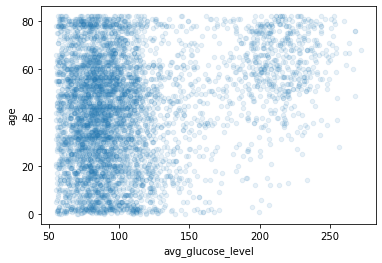

In [28]:
print("Les trois variables sont indépendante p-value >5%")
#remarque Nath : il me semble qu'il est nécessaire d'utiliser la fonction pearsonr pour déterminer les p-value, voire mon bout de code
# après le graphe, à ajouter ici si ça te convient Yann.

#remarque Nath : peut-être partir de df_new qui contient les valeurs nettoyées
dfnum=df_new[['age','avg_glucose_level','bmi']]
dfnum.corr()


df_new[df_new['age']<100].plot(kind='scatter', x='avg_glucose_level', y='age', alpha=0.1);
dfnum.corr()
# question Nath : pourquoi réutiliser une seconde fois la fonction corr() ? 

<div class= "alert alert-block alert-info">
    Compte-tenu des coefficients de corrélation plus proche de 0 que de 1, les variables semblent peu corrélées entre elles. 
</div>

In [29]:
# Remarques Nath sur les liaisons entre variables continues
# la fonction corr() permet de récupérer les coefficients de corélation entre les variables,
# Ne faut-il pas au préalable utiliser entre chaque couple de variables continues la fonction pearsonr() qui renvoie la p-value ?
# La p-value permet de dire si les variables sont indépendantes alors que le coef de corrélation permet de dire à quel point
# elles sont corrélées positivement ou négativement.

print(pd.DataFrame(pearsonr(df_new['age'], df_new['avg_glucose_level']), index=['pearson_coeff','p-value'], columns=['age/avg_glucose_level']))
print(pd.DataFrame(pearsonr(df_new['age'], df_new['bmi']), index=['pearson_coeff','p-value'], columns=['age/bmi']))
print(pd.DataFrame(pearsonr(df_new['avg_glucose_level'], df_new['bmi']), index=['pearson_coeff','p-value'], columns=['avg_glucose_level/bmi']))

               age/avg_glucose_level
pearson_coeff           2.381711e-01
p-value                 7.856311e-67
                     age/bmi
pearson_coeff   3.259425e-01
p-value        8.995421e-127
               avg_glucose_level/bmi
pearson_coeff           1.687514e-01
p-value                 5.927281e-34


In [53]:
corr = df_new.corr()
corr.style.background_gradient(cmap="coolwarm").format(precision=2)
#La variable qui a la corrélation la plus forte avec la crise cardiaque est l'âge, celle qui a le moins de corrélation contrairement à ce que l'on pourrait supposer est le bmi

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.00,0.28,0.26,0.24,0.33,0.25
hypertension,0.28,1.00,0.11,0.17,0.16,0.13
heart_disease,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.24,0.17,0.16,1.00,0.17,0.13
bmi,0.33,0.16,0.04,0.17,1.00,0.04
stroke,0.25,0.13,0.13,0.13,0.04,1.00


In [31]:
df_plot = df_new[["stroke","bmi"]]

In [32]:
df_plot["q"] = pd.qcut(df_plot["bmi"], q=4).cat.codes

C:\Users\louis.nouraud\AppData\Local\Temp\ipykernel_23620\4108149694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["q"] = pd.qcut(df_plot["bmi"], q=4).cat.codes


In [33]:
df_plot = df_plot.drop(columns="bmi")

In [34]:
df_plot = df_plot.groupby(["q", "stroke"]).size().reset_index(name='counts')

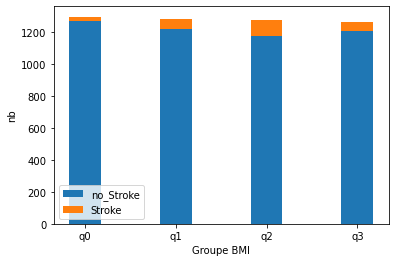

In [50]:
#Découper les BMI par groupe de "obésité" vs "sain"

labels = df_plot["q"].unique().tolist()
labels = ["q"+str(i) for i in labels]
#labels = 'q'.join(str(labels) for n in labels)
stroke = df_plot["counts"].loc[df_plot["stroke"]==1].tolist()
no_stroke = df_plot["counts"].loc[df_plot["stroke"]==0].tolist()

width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, no_stroke, width, label = "no_Stroke")
ax.bar(labels, stroke, width, bottom = no_stroke, label = "Stroke")

ax.set_ylabel("nb")
ax.set_xlabel("Groupe BMI")
ax.legend()

plt.show()

In [340]:
#Le fait d'être dans une tranche de bmi élevée n'augmente que de peu le risque d'avoir une crise cardiaque.

<a class="anchor" name="3.2"></a>
## 3.2 Analyse des liaisons entre les variables catégorielles

In [31]:
dfcat=df_new[['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status','stroke']]


table = pd.crosstab(dfcat['work_type'],dfcat['smoking_status'])

resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]
la_liste = resultats_test[3]
print("- Statistique : ", statistique, "\n- P-value : ", p_valeur, "\n- Degré de liberté : ",degre_liberte)

table

- Statistique :  377.3717444669619 
- P-value :  1.2904967632961852e-76 
- Degré de liberté :  8


smoking_status,formerly smoked,never smoked,smokes
work_type,,,
Govt_job,133,404,120
Never_worked,0,22,0
Private,531,1851,543
Self-employed,208,487,124
children,13,672,2


<div class= "alert alert-block alert-info">
    P-Value < 5% donc on rejette H0, les variables work_type et Smoking_status sont dépendantes 
</div>

In [43]:
# Ajout Nathalie pour trouver le niveau de corrélation entre les 2 variables
def V_cramer(cont_table, N):
    k = cont_table.shape[0]
    r = cont_table.shape[1]
    k_tilde = k - (k-1)**2/(N-1)
    r_tilde = r - (r-1)**2/(N-1)
    num = max(0, statistique/N-((k-1)*(r-1))/(N-1))
    denom = min(k_tilde-1, r_tilde-1)
    v_cramer=np.sqrt(num/denom)
    return v_cramer

print("- V_Cramer : ", V_cramer(table, df_new.shape[0]))


- V_Cramer :  0.1901474428195644


<div class= "alert alert-block alert-info">
    Le V_Cramer n'est pas très élevé (plus proche de 0 que de 1), les variables work_type et Smoking_status ne sont pas très corrélées sans que ce soit négligeable.
</div>

In [44]:
# Ajout Nathalie : Liaison entre heart_disease et stroke
table = pd.crosstab(dfcat['heart_disease'],dfcat['stroke'])
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]
la_liste = resultats_test[3]
print("- Statistique : ", statistique, "\n- P-value : ", p_valeur, "\n- Degré de liberté : ",degre_liberte)

print("- V_Cramer : ", V_cramer(table, df.shape[0]))

- Statistique :  90.25956125843324 
- P-value :  2.0887845685229236e-21 
- Degré de liberté :  1
- V_Cramer :  0.1321779325804356


<div class= "alert alert-block alert-info">
    P-Value < 5% donc on rejette H0, les variables heart_disease et stroke sont dépendantes.</br>
    Le V_Cramer n'est pas très élevé (plus proche de 0 que de 1), les variables heart_disease et stroke ne sont pas très corrélées sans que ce soit négligeable.
</div>

In [45]:
#https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26

categorical_features=identify_nominal_columns(df)
categorical_features
['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status','stroke']



complete_correlation= associations(df_new, filename= 'complete_correlation.png', figsize=(10,10))


df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)



categorical_correlation= associations(dfcat, filename= 'categorical_correlation.png', figsize=(10,10))

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

<a class="anchor" name="3.3"></a>
## 3.3 Liaison entre variables quantitatives et qualitatives

In [46]:
# Ajout Nathalie

# Analyse de l'influence de age sur stroke
result = statsmodels.formula.api.ols('stroke ~ age', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
age,1.0,14.247810,14.247810,326.916568,7.030778e-71
Residual,5108.0,222.618922,0.043582,NaN,NaN


<div class= "alert alert-block alert-info">
    La p-value (PR(>F)) est inférieur à 5% donc on rejette l'hypothèse selon laquelle l'âge n'influe pas sur stroke.
</div>

## Festival de graphique

No handles with labels found to put in legend.


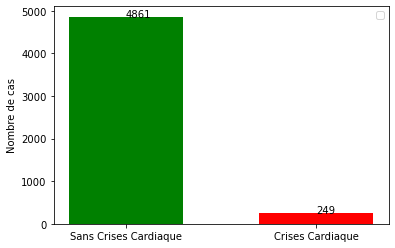

In [47]:
N1 = len(df_new[df_new['stroke']==0])
N2 = len(df_new[df_new['stroke'] == 1])


plt.bar([1],[N1], color = ['green'], width =  [0.6,0.5])
plt.bar([2],[N2], color = ['red'], width =  [0.6,0.5])

plt.xticks([1,2], ['Sans Crises Cardiaque','Crises Cardiaque'])


plt.ylabel('Nombre de cas')


plt.text(1,N1,N1)
plt.text(2,N2,N2)
plt.legend();

No handles with labels found to put in legend.


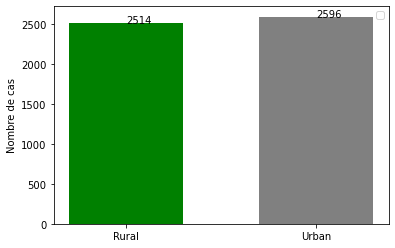

In [48]:
N1 = len(df_new[df_new['Residence_type']=='Rural'])
N2 = len(df_new[df_new['Residence_type'] == 'Urban'])


plt.bar([1],[N1], color = ['green'], width =  [0.6,0.5])
plt.bar([2],[N2], color = ['grey'], width =  [0.6,0.5])

plt.xticks([1,2], ['Rural','Urban'])


plt.ylabel('Nombre de cas')


plt.text(1,N1,N1)
plt.text(2,N2,N2)
plt.legend();